# Sinkhorn in All Flavors

We provide in this example a detailed walk-through some of the functionalities of the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm, including the computation of {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence`.

In [3]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [4]:
import functools

import ott
from ott.geometry import geometry, pointcloud
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

## From texts to word histograms

We adapt a [keras NLP tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/) to preprocess raw text (here a subset of texts from the [newsgroup20](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) database) and turn them into word embeddings histograms; see [here](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi) for detailed preprocessing.

This helps us recover 635 histograms supported on 4000 words, each represented by a 50-dimensional vector.

In [ ]:
# X contains 4000 word embeddings in dimension 50 , HIST a 653 x 4000 (row-normalized) matrix of histograms.
print(
    f"{HIST.shape[0]} texts supported on up to {HIST.shape[1]} words of dimension {X.shape[1]}"
)

653 texts supported on up to 4000 words of dimension 50


## Pairwise Sinkhorn divergences

Before setting a value for `epsilon`, let's get a feel of what the {class}`~ott.geometry.pointcloud.PointCloud` of embeddings looks like in terms of distances.

In [ ]:
geom = pointcloud.PointCloud(X)
print(
    "median:",
    geom.median_cost_matrix,
    " mean:",
    geom.mean_cost_matrix,
    " max:",
    jnp.max(geom.cost_matrix),
)

median: 0.40351653  mean: 0.41272432  max: 1.4388262


Store $4000 \times 4000$ cost matrix once and for all.

In [ ]:
cost = geom.cost_matrix

We now define a {func}`jitted <jax.jit>` version of the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` using a double {func}`~jax.vmap` to compute in one go the pairwise matrix of Sinkhorn divergence between two sets of histograms. Jitting is super important to achieve efficiency, don't forget to wrap whatever you do with a {func}`~jax.jit` if you want to run at scale. Note also how we set a higher convergence `threshold` (default would be $10^{-3}$) to ensure slightly faster execution. Finally, the triple instantiation of `cost` is not a bug: it just describes that the computation of each {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` will trigger the computation of three regularized OT problems using {class}`~ott.solvers.linear.sinkhorn.Sinkhorn`. In principle, each could have its own cost matrix. In this case they are all shared since the histograms are supported on the same set of words by design. 

In [ ]:
sink_div = jax.jit(
    jax.vmap(
        lambda HIST_1, HIST_2, cost, epsilon: jax.vmap(
            lambda hist_1, hist_2, cost, epsilon: sinkhorn_divergence(
                geometry.Geometry,
                cost,
                cost,
                cost,
                epsilon=epsilon,
                a=hist_1,
                b=hist_2,
                sinkhorn_kwargs={"threshold": 1e-2},
            ).divergence,
            in_axes=[0, None, None, None],
        )(HIST_1, HIST_2, cost, epsilon),
        in_axes=[None, 0, None, None],
    )
)

When setting `epsilon` to `None`, the algorithms will default to $0.05$ of the mean distance described in the geometry. This is no magical number, but rather a simple statistic of the scale of the problem. We recommend that you tune `epsilon` by yourself, but using `None` might avoid common issues (such as running {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` with a very small `epsilon` while the cost matrices are large).

In [ ]:
print("Default epsilon is: ", geom.epsilon)

Default epsilon is:  0.020636216


Compute now a pairwise $30 \times 30$ matrix of Sinkhorn divergences (about 1000 divergences in total). We pick 30 different texts twice.

In [ ]:
HIST_a = jnp.array(HIST[0:30])
HIST_b = jnp.array(HIST[-30:])
print(HIST_a.shape, HIST_b.shape, cost.shape)

(30, 4000) (30, 4000) (4000, 4000)


Dry run with large epsilon value to force {func}`~jax.jit` compilation before computing timings. This only makes sense within this tutorial.

In [ ]:
DIV = sink_div(HIST_a, HIST_b, cost, 10000)

We now carry out divergence computations and plot their matrix for various `epsilon`.

In [ ]:
DIV, ran_in = [], []
epsilons = [None, 5e-2, 1e-1]
for epsilon in epsilons:
    tic = time.perf_counter()
    DIV.append(sink_div(HIST_a, HIST_b, cost, epsilon).block_until_ready())
    toc = time.perf_counter()
    ran_in.append(toc - tic)

Notice how smaller `epsilon` has a huge impact on time (far longer). Larger `epsilon` values result in less spiked values with, however, a similar  relative pattern. As `epsilon` grows, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` converges to a quantity directly related to the energy distance / MMD.

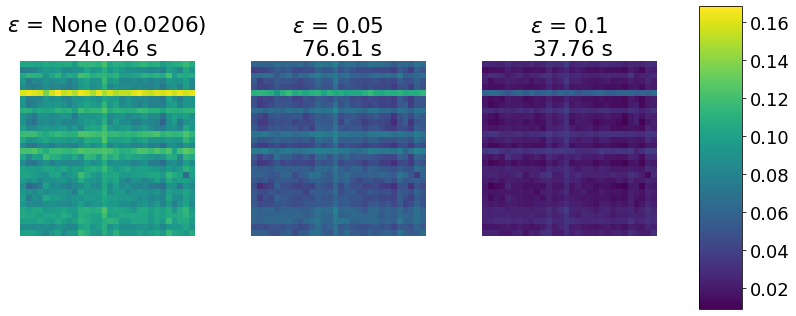

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.tight_layout()
axes = [axes[0], axes[1], axes[2]]
vmin = min([jnp.min(div) for div in DIV])
vmax = max([jnp.max(div) for div in DIV])

for epsilon, DIV_, ran_in_, ax_ in zip(epsilons, DIV, ran_in, axes):
    im = ax_.imshow(DIV_, vmin=vmin, vmax=vmax)
    eps = f" ({geom.epsilon:.4f})" if epsilon is None else ""
    ax_.set_title(
        r"$\varepsilon$ = " + str(epsilon) + eps + f"\n {ran_in_:.2f} s"
    )
    ax_.axis("off")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## The impact of $\varepsilon$ on convergence

We study in more detail how `epsilon` impacts the convergence of the algorithm. We now restrict our attention to the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm (not the divergence). We define first a `my_sinkhorn` function to handle computations of {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` with suitable parameters for this notebook.

In [ ]:
def my_sinkhorn(
    geom: geometry.Geometry, a: jnp.ndarray, b: jnp.ndarray, **kwargs
):
    prob = linear_problem.LinearProblem(geom, a=a, b=b)
    # recomputing error every iteration for plots
    # more iterations than the default setting to see full curves
    solver = sinkhorn.Sinkhorn(
        inner_iterations=1, max_iterations=10_000, **kwargs
    )
    return solver(prob)

We select now two text histograms. We will aim for texts that are supported on more than 1000 words each.

In [ ]:
ind = jnp.argsort(jnp.sum(jnp.array(HIST) > 0, axis=1))
a, b = HIST[ind[-2]], HIST[ind[-1]]
print(
    f"Histogram a supported on {jnp.sum(a >0)} words, b on {jnp.sum(b >0)} words"
)

Histogram a supported on 1121 words, b on 1162 words


We start by looking more closely into the time needed for {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` to converge for various `epsilon` values.

In [ ]:
out_eps, leg_eps = [], []
epsilons = [1e-3, 0.3 * 1e-2, 1e-2, 0.3 * 1e-1, 1e-1]
ran_in = np.zeros((len(epsilons),))
for i, epsilon in enumerate(epsilons):
    tic = time.perf_counter()
    out_eps.append(my_sinkorn(geometry.Geometry(cost, epsilon=epsilon), a, b))
    toc = time.perf_counter()
    ran_in[i] = toc - tic
    leg_eps.append(
        r"$\varepsilon$" + f"= {epsilon}, cost = {out_eps[-1].reg_ot_cost:.2f}"
    )

These execution times can then be plotted, to result in the following graph:

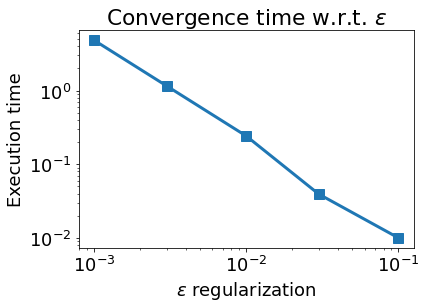

In [ ]:
plt.plot(epsilons, ran_in, marker="s", markersize=10, linewidth=3)

We now take a closer look at the actual convergence curves of the error of the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm (i.e. marginal error). We introduce a `plot_results` function to visualize this convergence, see [here](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi)).

We can now look more closely into `epsilon`'s impact. Obviously, the convergence is slower with smaller regularization: there is a trade-off between speed and how close to the original LP solution we want to be. In the absence of a strong opinion on how small regularization should, we advise that you start using larger `epsilon`, since this makes your life substantially easier!

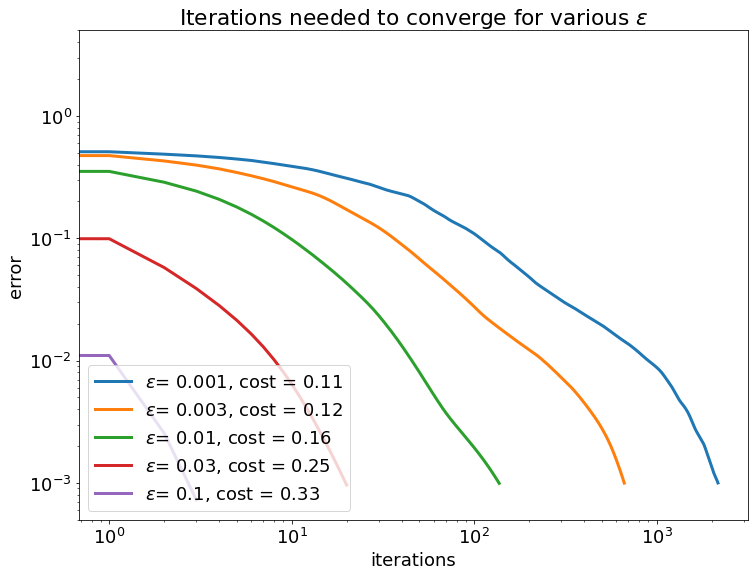

In [ ]:
plot_results(
    out_eps,
    leg_eps,
    title=r"Iterations needed to converge for various $\varepsilon$",
    xlabel="iterations",
    ylabel="error",
)

## Speeding up Sinkhorn

### Fixed momentum

{cite}`thibault:21` proposed to use a {class}`~ott.solvers.linear.acceleration.Momentum` term to (hopefully) accelerate the convergence of the Sinkhorn algorithm. This is controlled by the `momentum` parameter when calling {class}`~ott.solvers.linear.sinkhorn.Sinkhorn`. We vary that parameter along with various `epsilon` regularization strengths. As can be seen below, a `momentum` parameter larger than 1.0 (also known as extrapolation or over-relaxation) helps, but can also be more unstable. 

We first compute baseline curves for three $\varepsilon$ values:

In [ ]:
epsilons = [1e-4, 1e-3, 1e-2]
out_baseline, leg_baseline = [], []
for epsilon in epsilons:
    out_baseline.append(
        my_sinkorn(geometry.Geometry(cost, epsilon=epsilon), a, b)
    )
    leg_baseline.append("Baseline")

Test now using ``momentum`` values lower and larger than 1. Run computations first

In [ ]:
out_mom, leg_mom = [], []
for i, epsilon in enumerate(epsilons):
    out_mom.append([out_baseline[i]])  # initialize with baseline
    leg_mom.append([leg_baseline[i]])  # initialize with baseline
    for mom in [0.8, 1.05, 1.1, 1.3]:
        out_mom[i].append(
            my_sinkorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                momentum=acceleration.Momentum(value=mom),
            )
        )
        leg_mom[i].append(f"Momentum : {mom}")

Plot them next. 

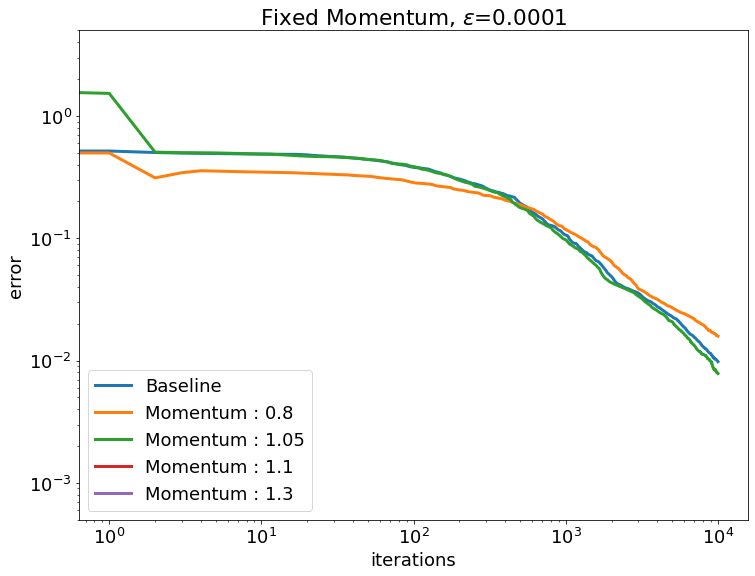

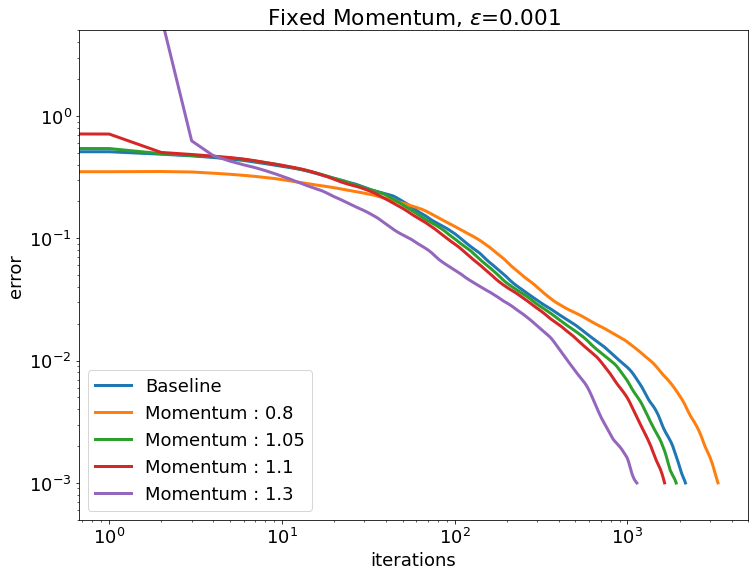

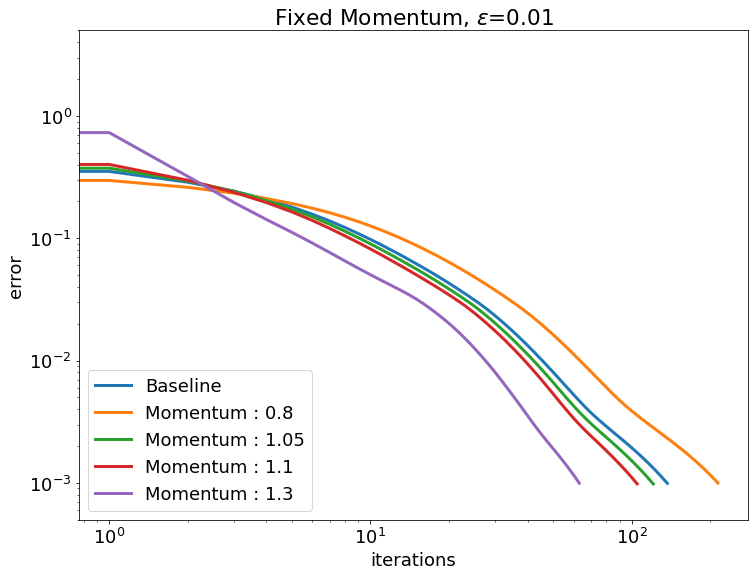

In [ ]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_mom[i],
        leg_mom[i],
        title=r"Fixed Momentum, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

You might have noticed in the first set of curves that the values for `momentum` $1.1$ and $1.3$ are not displayed. For that small $\varepsilon=0.0001$,  the error has diverged from the first update.

In [ ]:
[out_mom[0][3].errors], [
    out_mom[0][4].errors
]  # Computation diverges from first iteration for small epsilon, high momentum.

([DeviceArray([inf, -1., -1., ..., -1., -1., -1.], dtype=float32)],
 [DeviceArray([inf, -1., -1., ..., -1., -1., -1.], dtype=float32)])

### Adaptive momentum

{cite}`lehmann:21` propose a simple rule to update the {class}`~ott.solvers.linear.acceleration.Momentum` term adaptively, after a few {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` iterations, by tracking the convergence of the algorithm to compute a momentum parameter. We test this approach with various `epsilon` values.

In [ ]:
out_chg_mom, leg_chg_mom = [], []
for i, epsilon in enumerate(epsilons):
    out_chg_mom.append([out_baseline[i]])
    leg_chg_mom.append([leg_baseline[i]])
    for chg_momentum_from in [10, 20, 50, 200, 1000]:
        out_chg_mom[i].append(
            my_sinkorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                momentum=acceleration.Momentum(start=chg_momentum_from),
            )
        )
        leg_chg_mom[i].append(f"Change after {chg_momentum_from} it.")

As can be seen in the curves below, this seems to be a very effective and robust way to speed up the algorithm.

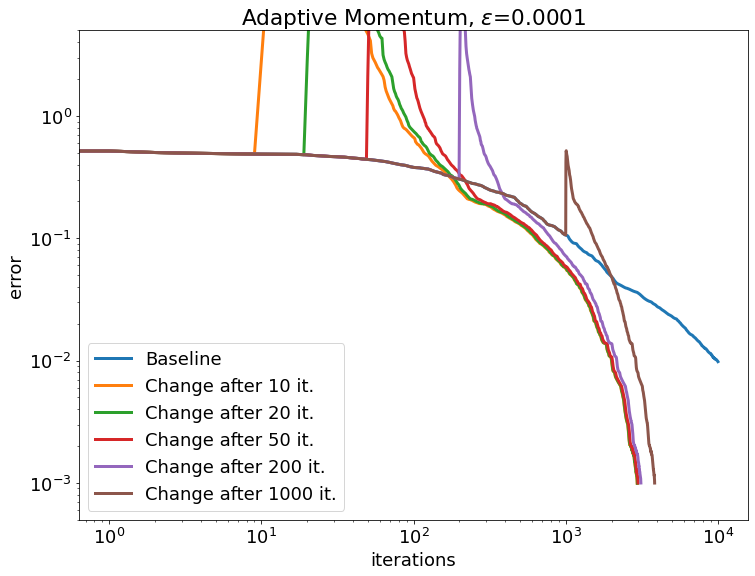

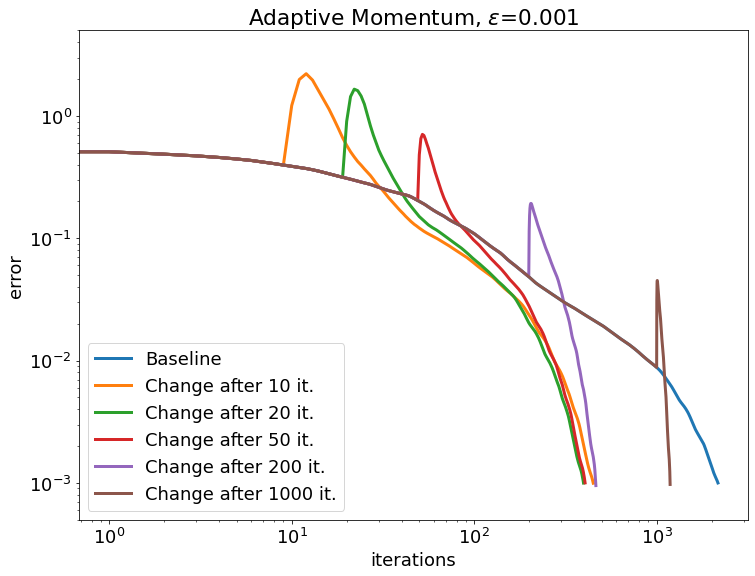

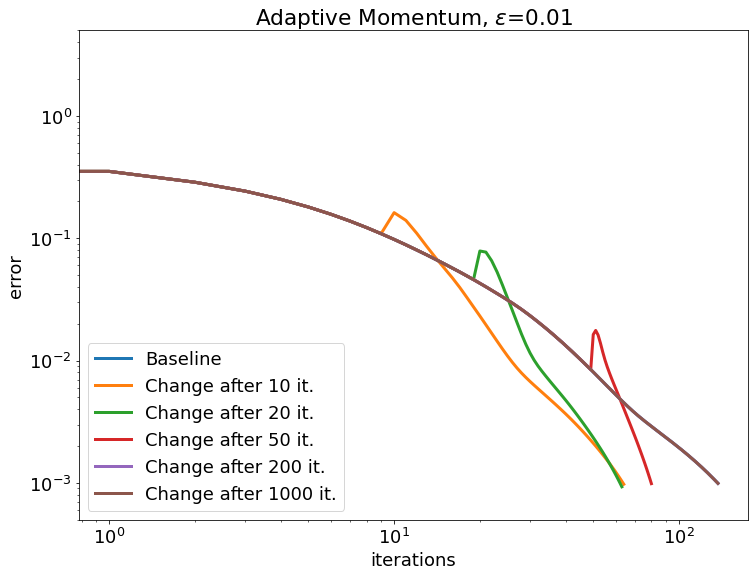

In [ ]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_chg_mom[i],
        leg_chg_mom[i],
        title=r"Adaptive Momentum, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### $\varepsilon$ decay

It also possible to use so called {class}`~ott.geometry.epsilon_scheduler.Epsilon` decay, which consists in starting the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` iterations with a large $\varepsilon$ value that is progressively decreased using a multiplicative update.

In [ ]:
out_scaling, leg_scaling = [], []
for i, epsilon in enumerate(epsilons):
    out_scaling.append([out_baseline[i]])
    leg_scaling.append([leg_baseline[i]])
    for decay in [0.8, 0.95]:
        for init in [5, 50, 100]:
            out_scaling[i].append(
                my_sinkorn(
                    geometry.Geometry(
                        cost, epsilon=epsilon, init=init * epsilon, decay=decay
                    ),
                    a,
                    b,
                )
            )
            leg_scaling[i].append(
                rf"Decay: {decay}, Init: {init} $\varepsilon$"
            )

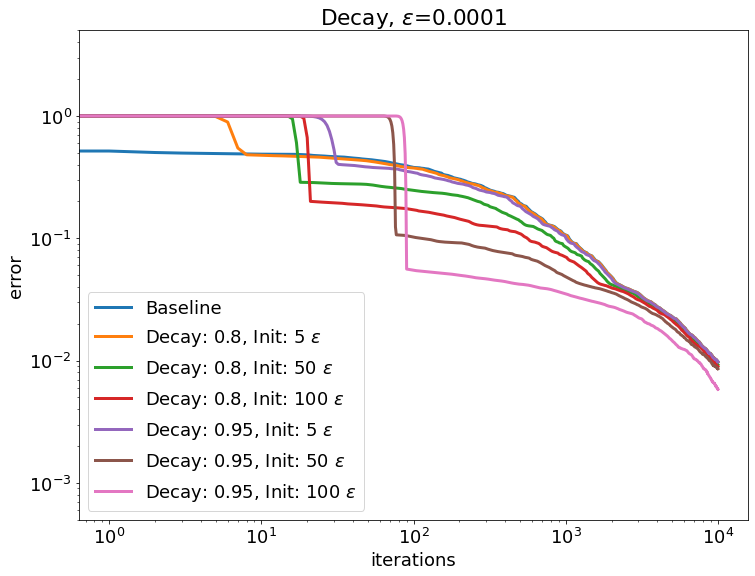

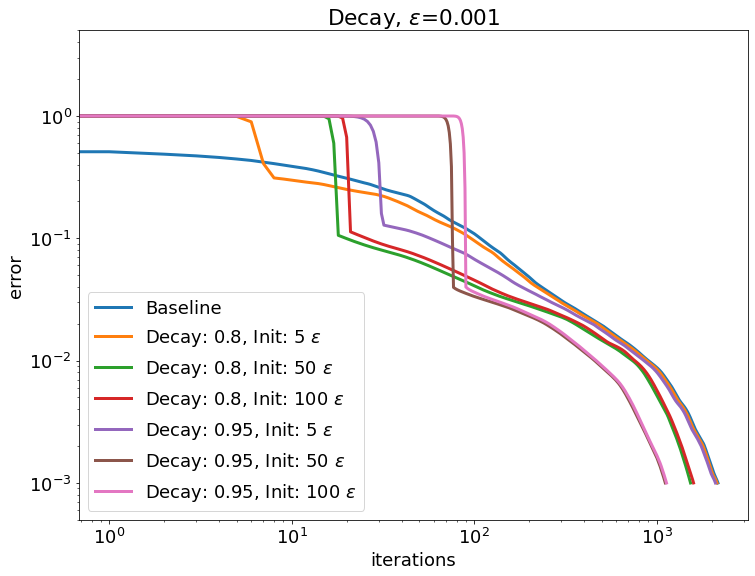

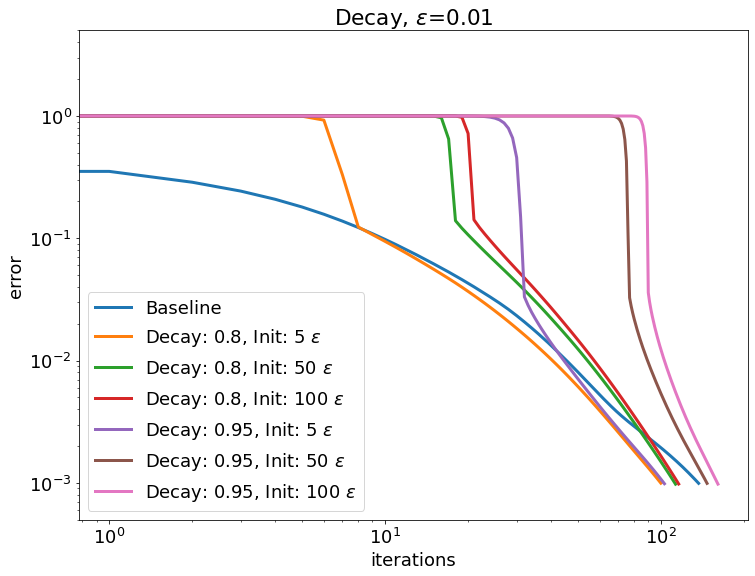

In [ ]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_scaling[i],
        leg_scaling[i],
        title=rf"Decay, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### Anderson acceleration

Using {class}`~ott.solvers.linear.acceleration.AndersonAcceleration` on the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm provides mixed results, worsening performance for smaller `epsilon` regularization, and slightly improving it as the regularization gets larger.

In [ ]:
out_anderson, leg_anderson = [], []

for i, epsilon in enumerate(epsilons):
    out_anderson.append([out_baseline[i]])
    leg_anderson.append([leg_baseline[i]])
    for memory in [3, 5, 8, 15]:
        out_anderson[i].append(
            my_sinkorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                anderson=acceleration.AndersonAcceleration(memory=memory),
            )
        )
        leg_anderson[i].append(f"Anderson Acceleration: {memory}")

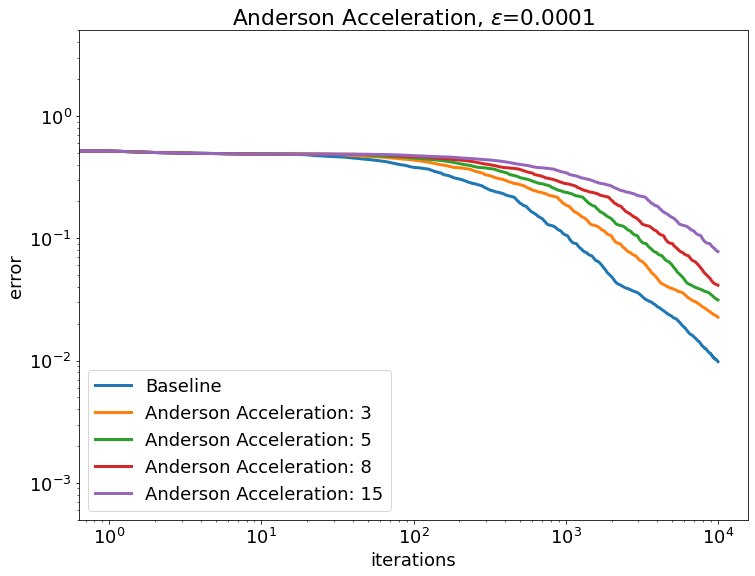

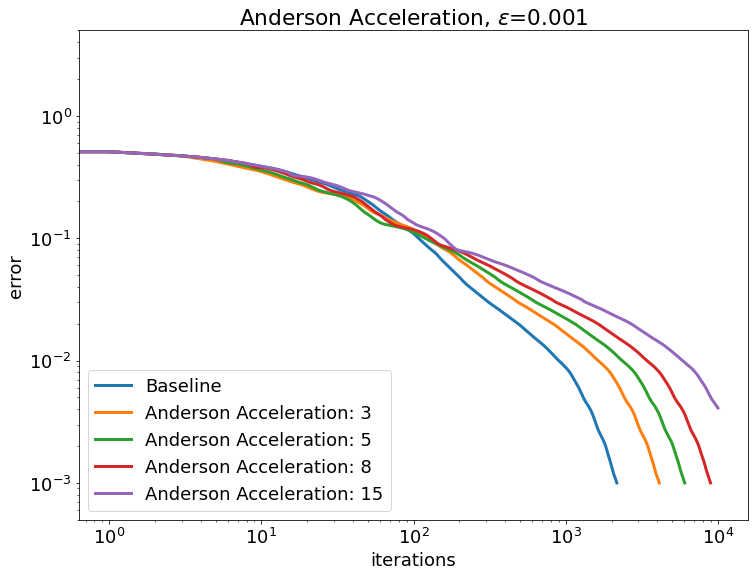

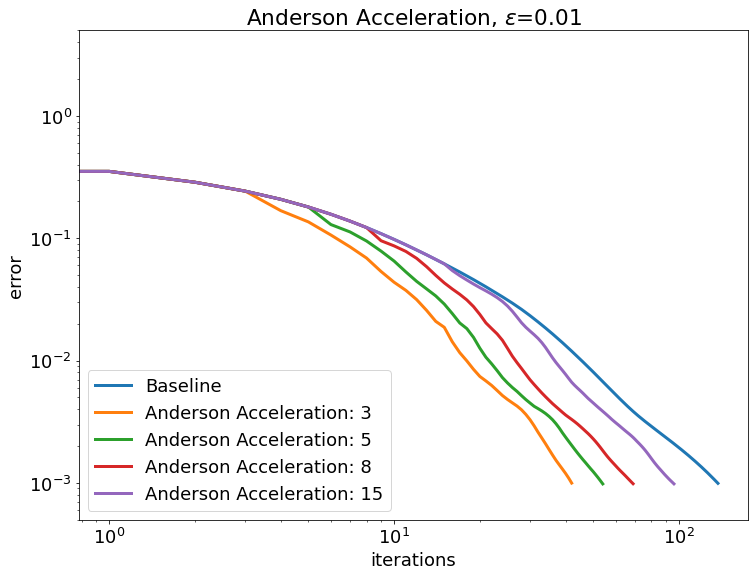

In [ ]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_anderson[i],
        leg_anderson[i],
        title=r"Anderson Acceleration, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### Decay and momentum

An interesting direction to accelerate convergence is to update the {class}`~ott.solvers.linear.acceleration.Momentum` after the {class}`~ott.geometry.epsilon_scheduler.Epsilon` decay schedule has converged. 

In [ ]:
out_mixed, leg_mixed = [], []
for i, epsilon in enumerate(epsilons):
    out_mixed.append([out_baseline[i]])
    leg_mixed.append([leg_baseline[i]])
    for decay, init, chg_momentum_from in [
        [0.5, 10, 10],
        [0.7, 5, 20],
        [0.9, 10, 50],
        [0.99, 2, 100],
    ]:
        out_mixed[i].append(
            my_sinkorn(
                geometry.Geometry(
                    cost, epsilon=epsilon, init=init * epsilon, decay=decay
                ),
                a,
                b,
                momentum=acceleration.Momentum(start=chg_momentum_from),
            )
        )
        leg_mixed[i].append(
            rf"Decay: {decay}, Init: {init}$\varepsilon$, ChgMom: {chg_momentum_from}"
        )

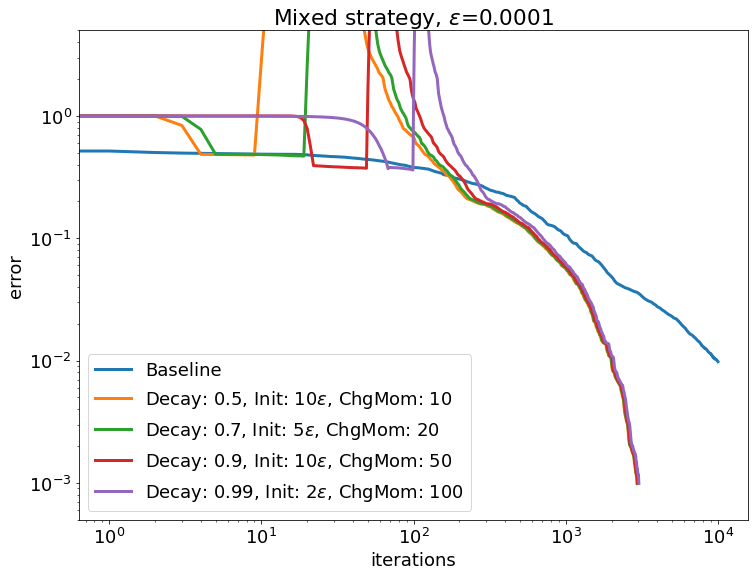

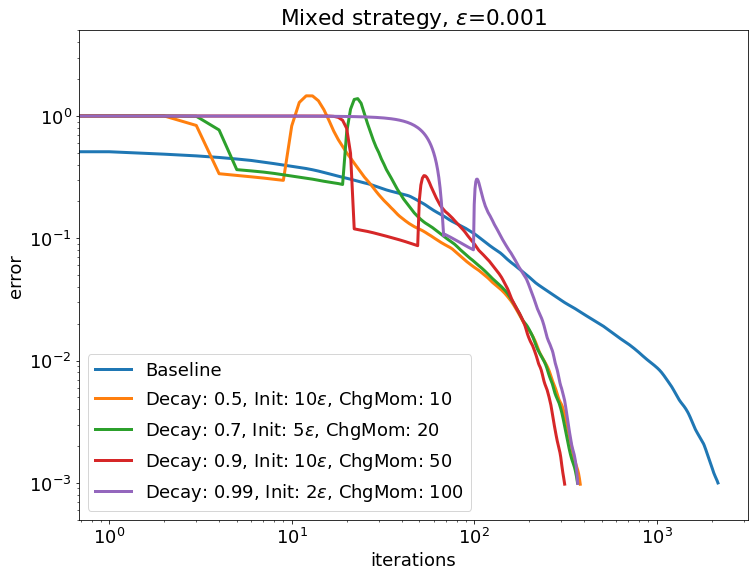

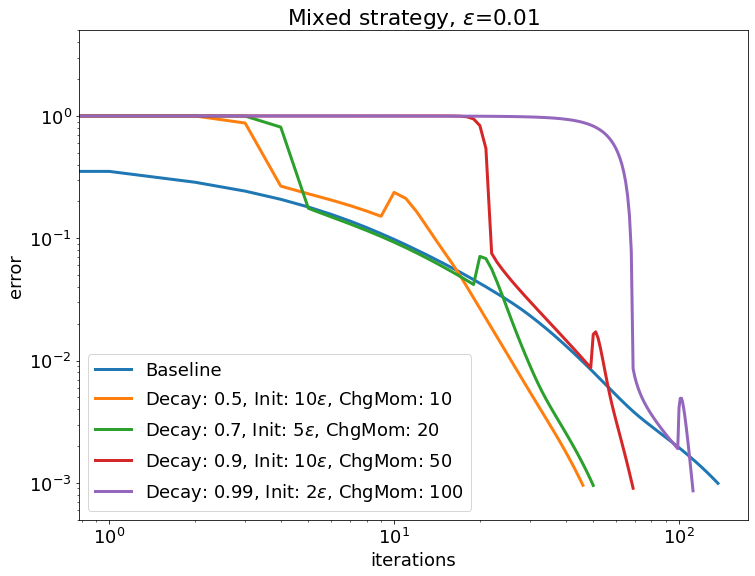

In [ ]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_mixed[i],
        leg_mixed[i],
        title=rf"Mixed strategy, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )